In [19]:
_EPSILON = 1e-08

import numpy as np
import pandas as pd
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
# import sys

from termcolor import colored
from tensorflow.contrib.layers import fully_connected as FC_Net
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

import import_data as impt
import utils_network as utils

from class_DeepHit import Model_DeepHit
from utils_eval import c_index, brier_score, weighted_c_index, weighted_brier_score


def load_logging(filename):
    data = dict()
    with open(filename) as f:
        def is_float(input):
            try:
                num = float(input)
            except ValueError:
                return False
            return True

        for line in f.readlines():
            if ':' in line:
                key,value = line.strip().split(':', 1)
                if value.isdigit():
                    data[key] = int(value)
                elif is_float(value):
                    data[key] = float(value)
                elif value == 'None':
                    data[key] = None
                else:
                    data[key] = value
            else:
                pass # deal with bad lines of text here    
    return data



##### MAIN SETTING
OUT_ITERATION               = 5

data_mode                   = 'GPU' #METABRIC, SYNTHETIC
seed                        =  1234

EVAL_TIMES                  = [12, 24, 36] # evalution times (for C-index and Brier-Score)


##### IMPORT DATASET
'''
    num_Category            = max event/censoring time * 1.2 (to make enough time horizon)
    num_Event               = number of evetns i.e. len(np.unique(label))-1
    max_length              = maximum number of measurements
    x_dim                   = data dimension including delta (num_features)
    mask1, mask2            = used for cause-specific network (FCNet structure)
'''
if data_mode == 'SYNTHETIC':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_SYNTHETIC(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'METABRIC':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_METABRIC(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'SEER':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_SEER(norm_mode = 'standard')
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
elif data_mode == 'GPU':
    (x_dim), (data, time, label), (mask1, mask2) = impt.import_dataset_GPU(norm_mode = "standard")
    percentiles = np.linspace(2, 100, 20)  # Adjust as needed
    EVAL_TIMES = np.percentile(time.flatten(),percentiles)
else:
    print('ERROR:  DATA_MODE NOT FOUND !!!')

_, num_Event, num_Category  = np.shape(mask1)  # dim of mask1: [subj, Num_Event, Num_Category]



in_path = data_mode + '/results/'

if not os.path.exists(in_path):
    os.makedirs(in_path)


FINAL1 = np.zeros([num_Event, len(EVAL_TIMES), OUT_ITERATION])
FINAL2 = np.zeros([num_Event, len(EVAL_TIMES), OUT_ITERATION])


for out_itr in range(OUT_ITERATION):
    in_hypfile = in_path + '/itr_' + str(out_itr) + '/hyperparameters_log.txt'
    in_parser = load_logging(in_hypfile)


    ##### HYPER-PARAMETERS
    mb_size                     = in_parser['mb_size']

    iteration                   = in_parser['iteration']

    keep_prob                   = in_parser['keep_prob']
    lr_train                    = in_parser['lr_train']

    h_dim_shared                = in_parser['h_dim_shared']
    h_dim_CS                    = in_parser['h_dim_CS']
    num_layers_shared           = in_parser['num_layers_shared']
    num_layers_CS               = in_parser['num_layers_CS']

    if in_parser['active_fn'] == 'relu':
        active_fn                = tf.nn.relu
    elif in_parser['active_fn'] == 'elu':
        active_fn                = tf.nn.elu
    elif in_parser['active_fn'] == 'tanh':
        active_fn                = tf.nn.tanh
    else:
        print('Error!')


    initial_W                   = tf.contrib.layers.xavier_initializer()

    alpha                       = in_parser['alpha']  #for log-likelihood loss
    beta                        = in_parser['beta']  #for ranking loss
    gamma                       = in_parser['gamma']  #for RNN-prediction loss
    parameter_name              = 'a' + str('%02.0f' %(10*alpha)) + 'b' + str('%02.0f' %(10*beta)) + 'c' + str('%02.0f' %(10*gamma))


    ##### MAKE DICTIONARIES
    # INPUT DIMENSIONS
    input_dims                  = { 'x_dim'         : x_dim,
                                    'num_Event'     : num_Event,
                                    'num_Category'  : num_Category}

    # NETWORK HYPER-PARMETERS
    network_settings            = { 'h_dim_shared'         : h_dim_shared,
                                    'h_dim_CS'          : h_dim_CS,
                                    'num_layers_shared'    : num_layers_shared,
                                    'num_layers_CS'    : num_layers_CS,
                                    'active_fn'      : active_fn,
                                    'initial_W'         : initial_W }


    # for out_itr in range(OUT_ITERATION):
    print ('ITR: ' + str(out_itr+1) + ' DATA MODE: ' + data_mode + ' (a:' + str(alpha) + ' b:' + str(beta) + ' c:' + str(gamma) + ')' )
    ##### CREATE DEEPFHT NETWORK
    tf.reset_default_graph()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)

    model = Model_DeepHit(sess, "DeepHit", input_dims, network_settings)
    saver = tf.train.Saver()

    sess.run(tf.global_variables_initializer())

    ### TRAINING-TESTING SPLIT
    (tr_data,te_data, tr_time,te_time, tr_label,te_label, 
     tr_mask1,te_mask1, tr_mask2,te_mask2)  = train_test_split(data, time, label, mask1, mask2, test_size=0.20, random_state=seed) 

    (tr_data,va_data, tr_time,va_time, tr_label,va_label, 
     tr_mask1,va_mask1, tr_mask2,va_mask2)  = train_test_split(tr_data, tr_time, tr_label, tr_mask1, tr_mask2, test_size=0.20, random_state=seed) 
    
    ##### PREDICTION & EVALUATION
    saver.restore(sess, in_path + '/itr_' + str(out_itr) + '/models/model_itr_' + str(out_itr))

    ### PREDICTION
    pred = model.predict(te_data)
    
    ### EVALUATION
    result1, result2 = np.zeros([num_Event, len(EVAL_TIMES)]), np.zeros([num_Event, len(EVAL_TIMES)])

    for t, t_time in enumerate(EVAL_TIMES):
        eval_horizon = int(t_time)

        if eval_horizon >= num_Category:
            print( 'ERROR: evaluation horizon is out of range')
            result1[:, t] = result2[:, t] = -1
        else:
            # calculate F(t | x, Y, t >= t_M) = \sum_{t_M <= \tau < t} P(\tau | x, Y, \tau > t_M)
            risk = np.sum(pred[:,:,:(eval_horizon+1)], axis=2) #risk score until EVAL_TIMES
            for k in range(num_Event):
                # result1[k, t] = c_index(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                # result2[k, t] = brier_score(risk[:,k], te_time, (te_label[:,0] == k+1).astype(float), eval_horizon) #-1 for no event (not comparable)
                result1[k, t] = weighted_c_index(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)
                result2[k, t] = weighted_brier_score(tr_time, (tr_label[:,0] == k+1).astype(int), risk[:,k], te_time, (te_label[:,0] == k+1).astype(int), eval_horizon) #-1 for no event (not comparable)

    FINAL1[:, :, out_itr] = result1
    FINAL2[:, :, out_itr] = result2

    ### SAVE RESULTS
    row_header = []
    for t in range(num_Event):
        row_header.append('Event_' + str(t+1))

    col_header1 = []
    col_header2 = []
    for t in EVAL_TIMES:
        col_header1.append(str(t) + 'yr c_index')
        col_header2.append(str(t) + 'yr B_score')

    # c-index result
    df1 = pd.DataFrame(result1, index = row_header, columns=col_header1)
    df1.to_csv(in_path + '/result_CINDEX_itr' + str(out_itr) + '.csv')

    # brier-score result
    df2 = pd.DataFrame(result2, index = row_header, columns=col_header2)
    df2.to_csv(in_path + '/result_BRIER_itr' + str(out_itr) + '.csv')

    ### PRINT RESULTS
    print('========================================================')
    print('ITR: ' + str(out_itr+1) + ' DATA MODE: ' + data_mode + ' (a:' + str(alpha) + ' b:' + str(beta) + ' c:' + str(gamma) + ')' )
    print('SharedNet Parameters: ' + 'h_dim_shared = '+str(h_dim_shared) + ' num_layers_shared = '+str(num_layers_shared) + 'Non-Linearity: ' + str(active_fn))
    print('CSNet Parameters: ' + 'h_dim_CS = '+str(h_dim_CS) + ' num_layers_CS = '+str(num_layers_CS) + 'Non-Linearity: ' + str(active_fn)) 

    print('--------------------------------------------------------')
    print('- C-INDEX: ')
    print(df1)
    print('--------------------------------------------------------')
    print('- BRIER-SCORE: ')
    print(df2)
    print('========================================================')


ITR: 1 DATA MODE: GPU (a:1.0 b:1.0 c:0)
INFO:tensorflow:Restoring parameters from GPU/results//itr_0/models/model_itr_0


INFO:tensorflow:Restoring parameters from GPU/results//itr_0/models/model_itr_0


ITR: 1 DATA MODE: GPU (a:1.0 b:1.0 c:0)
SharedNet Parameters: h_dim_shared = 300 num_layers_shared = 2Non-Linearity: <function tanh at 0x752a200960d0>
CSNet Parameters: h_dim_CS = 50 num_layers_CS = 5Non-Linearity: <function tanh at 0x752a200960d0>
--------------------------------------------------------
- C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                     0.812633   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                     0.893396                     0.886929   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.873368                     0.862629   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.870229                      0.878518   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.880042              

INFO:tensorflow:Restoring parameters from GPU/results//itr_1/models/model_itr_1


ITR: 2 DATA MODE: GPU (a:1.0 b:1.0 c:0)
SharedNet Parameters: h_dim_shared = 200 num_layers_shared = 1Non-Linearity: <function relu at 0x752a17698e50>
CSNet Parameters: h_dim_CS = 300 num_layers_CS = 3Non-Linearity: <function relu at 0x752a17698e50>
--------------------------------------------------------
- C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                      0.83758   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                     0.892469                     0.888381   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.872687                     0.861937   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.870151                      0.878938   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.882258             

INFO:tensorflow:Restoring parameters from GPU/results//itr_2/models/model_itr_2


ITR: 3 DATA MODE: GPU (a:1.0 b:5.0 c:0)
SharedNet Parameters: h_dim_shared = 100 num_layers_shared = 2Non-Linearity: <function tanh at 0x752a200960d0>
CSNet Parameters: h_dim_CS = 300 num_layers_CS = 5Non-Linearity: <function tanh at 0x752a200960d0>
--------------------------------------------------------
- C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                     0.794055   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                     0.897155                     0.883635   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.870846                     0.860228   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.867247                      0.877411   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.878684             

INFO:tensorflow:Restoring parameters from GPU/results//itr_3/models/model_itr_3


ITR: 4 DATA MODE: GPU (a:1.0 b:3.0 c:0)
SharedNet Parameters: h_dim_shared = 300 num_layers_shared = 5Non-Linearity: <function relu at 0x752a17698e50>
CSNet Parameters: h_dim_CS = 100 num_layers_CS = 1Non-Linearity: <function relu at 0x752a17698e50>
--------------------------------------------------------
- C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                     0.800955   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                      0.87262                     0.884327   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.872473                     0.864385   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.871102                      0.879716   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.882146             

INFO:tensorflow:Restoring parameters from GPU/results//itr_4/models/model_itr_4


ITR: 5 DATA MODE: GPU (a:1.0 b:5.0 c:0)
SharedNet Parameters: h_dim_shared = 300 num_layers_shared = 1Non-Linearity: <function tanh at 0x752a200960d0>
CSNet Parameters: h_dim_CS = 100 num_layers_CS = 2Non-Linearity: <function tanh at 0x752a200960d0>
--------------------------------------------------------
- C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                     0.788747   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                     0.890934                     0.889015   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.873158                     0.861954   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.868246                      0.877576   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.878698             

In [20]:
### FINAL MEAN/STD
# c-index result
df1_mean = pd.DataFrame(np.mean(FINAL1, axis=2), index = row_header, columns=col_header1)
df1_std  = pd.DataFrame(np.std(FINAL1, axis=2), index = row_header, columns=col_header1)
df1_mean.to_csv(in_path + '/result_CINDEX_FINAL_MEAN.csv')
df1_std.to_csv(in_path + '/result_CINDEX_FINAL_STD.csv')

# brier-score result
df2_mean = pd.DataFrame(np.mean(FINAL2, axis=2), index = row_header, columns=col_header2)
df2_std  = pd.DataFrame(np.std(FINAL2, axis=2), index = row_header, columns=col_header2)
df2_mean.to_csv(in_path + '/result_BRIER_FINAL_MEAN.csv')
df2_std.to_csv(in_path + '/result_BRIER_FINAL_STD.csv')


### PRINT RESULTS
print('========================================================')
print('- FINAL C-INDEX: ')
print(df1_mean)
print('--------------------------------------------------------')
print('- FINAL BRIER-SCORE: ')
print(df2_mean)
print('========================================================')

- FINAL C-INDEX: 
         410.1969800135112yr c_index  524.9024191494399yr c_index  \
Event_1                         -1.0                     0.806794   

         629.7724240107663yr c_index  730.6063912795815yr c_index  \
Event_1                     0.889315                     0.886458   

         824.8287999737556yr c_index  916.6079055791829yr c_index  \
Event_1                     0.872506                     0.862227   

         1000.1864534707869yr c_index  1075.4097179652272yr c_index  \
Event_1                      0.869395                      0.878432   

         1151.4061320404815yr c_index  1227.4678490777778yr c_index  \
Event_1                      0.880366                      0.875931   

         1300.1079487652773yr c_index  1379.6184626781833yr c_index  \
Event_1                      0.874705                      0.877243   

         1458.900019488439yr c_index  1546.6036789491893yr c_index  \
Event_1                     0.878793                      0.878258

In [21]:
pred
pred.shape

(2000, 1, 3065)

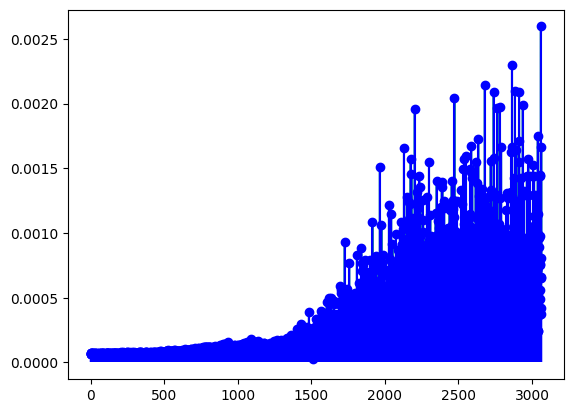

In [22]:
import matplotlib.pyplot as plt
values_to_plot = pred[0, 0, :]  # Extracting the first value along the last axis
plt.plot(values_to_plot)
 
plt.stem(values_to_plot, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.show()

In [24]:
values_to_plot = pred[0, 1, :]  # Extracting the first value along the last axis
plt.plot(values_to_plot)
 
plt.stem(values_to_plot, linefmt='b-', markerfmt='bo', basefmt=" ")
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1